<a href="https://colab.research.google.com/github/retrouvailles00/cs6120/blob/main/CS6120_ASSIGNMENT2_RuiLiu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sentencepiece
import os

!pip install transformers
from transformers import pipeline

import json,requests
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
import matplotlib.pyplot as plt


  Using cached transformers-4.34.0-py3-none-any.whl (7.7 MB)


In [3]:
def get_data_by_author_name(author_name):
  url = 'https://api.semanticscholar.org/graph/v1/author/search?query=' + str(author_name) + '&fields=name,citationCount,papers,papers.citationCount'
  j = requests.get(url).json()
  if j['data'] is not None:
    return j['data']

In [4]:
def citations(rec): return rec['citationCount']

def get_sorted_author_id(data):
  sorted_authorIds = [d['authorId'] for d in sorted(data, key=citations, reverse=True)]
  if len(sorted_authorIds) > 3:
    return sorted_authorIds[0:3]
  return sorted_authorIds

In [5]:
data = get_data_by_author_name("Noah Smith")

In [6]:
author_ids = get_sorted_author_id(data)

In [7]:
def get_paper_ids(author_ids):
  all_paper_ids = []
  for author_id in author_ids:
    paper = [x['papers'] for x in data if x["authorId"]==author_id]
    if len(paper) != 0:
      paper_ids = [paper['paperId'] for paper in sorted(paper[0], key=citations, reverse=True)]
      if len(paper_ids) > 4:
        paper_ids = paper_ids[0:4]
      all_paper_ids.append(paper_ids)
  return all_paper_ids

all_paper_ids = get_paper_ids(author_ids)

In [8]:
def get_titles_by_paper_id(paper_id):
  url = 'https://api.semanticscholar.org/graph/v1/paper/' + str(paper_id) + '?fields=title'
  j = requests.get(url).json()
  if j['title'] is not None:
    return j['title']

In [9]:
def get_titles(all_paper_ids):
  texts = []
  for paper_ids in all_paper_ids:
    for paper_id in paper_ids:
      title = get_titles_by_paper_id(paper_id)
      if title is None:
        continue
      else:
        texts.append(title)
  return texts

In [10]:
titles = get_titles(all_paper_ids)

In [11]:
def get_abstracts_by_paper_id(paper_id):
  url = 'https://api.semanticscholar.org/graph/v1/paper/' + str(paper_id) + '?fields=abstract'
  j = requests.get(url).json()
  if j['abstract'] is not None:
    return j['abstract']

def get_abstracts(all_paper_ids):
  texts = []
  for paper_ids in all_paper_ids:
    for paper_id in paper_ids:
      abstract = get_abstracts_by_paper_id(paper_id)
      if abstract is None:
        continue
      else:
        texts.append(abstract)
  return texts

In [12]:
abstracts = get_abstracts(all_paper_ids)

In [13]:
en_zh_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-zh")
zh_en_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-zh-en")

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [14]:
en_fr_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr")
fr_en_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")

In [15]:
def translate_en_zh_en(input):
  translated_context = []
  for context in input:
    context = en_zh_translator(context)
    if context is not None:
      translated_context.append(zh_en_translator(context[0]['translation_text'])[0]['translation_text'])
  return translated_context

In [16]:
def translate_en_fr_en(input):
  translated_context = []
  for context in input:
    context = en_fr_translator(context)
    if context is not None:
      translated_context.append(en_fr_translator(context[0]['translation_text'])[0]['translation_text'])
  return translated_context

In [17]:
def text_to_specter(s, model="allenai/specter2_base"):
  pipe = pipeline("feature-extraction", model=model)
  return pipe(s, return_tensors = "pt")[:,0,:].detach().numpy().reshape(-1)

In [18]:
def get_specters(input):
  specters = []
  for text in input:
    specter = text_to_specter(text).reshape(-1, 1)
    specters.append(specter)
  specters = np.array(specters).reshape(len(input), -1)
  return specters


In [19]:
def plot_cossim(specters):
  sim = cosine_similarity(specters)
  plt.imshow(sim)
  plt.colorbar()

In [20]:
##untranslated specters
titles_specters_en = get_specters(titles)
abstracts_specters_en = get_specters(abstracts)

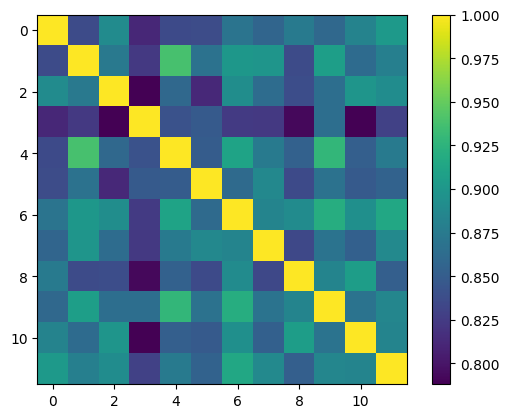

In [21]:
##plot for untranslated titles specters
plot_cossim(titles_specters_en)

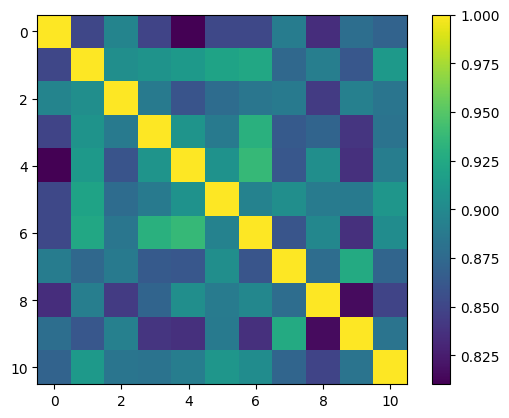

In [22]:
##plot for untranslated abstracts specters
plot_cossim(abstracts_specters_en)

In [23]:
translated_titles_zh = translate_en_zh_en(titles)
translated_titles_specters_zh = get_specters(translated_titles_zh)

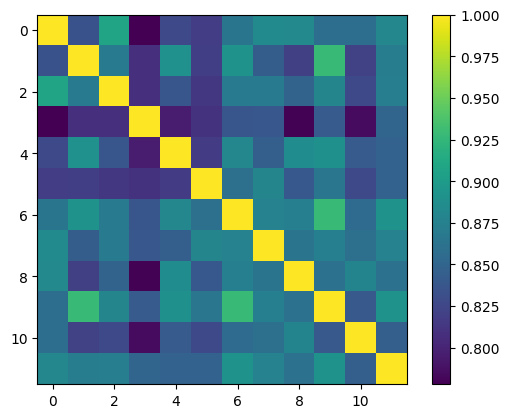

In [24]:
##plot for untranslated thru Chinese titles specters
plot_cossim(translated_titles_specters_zh)

{'whiskers': [<matplotlib.lines.Line2D at 0x7cb39fbe68c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7cb39fbe7310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7cb39fbe5ab0>,
 'medians': [<matplotlib.lines.Line2D at 0x7cb39fbe7d60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7cb39fbe6ef0>,
 'means': []}

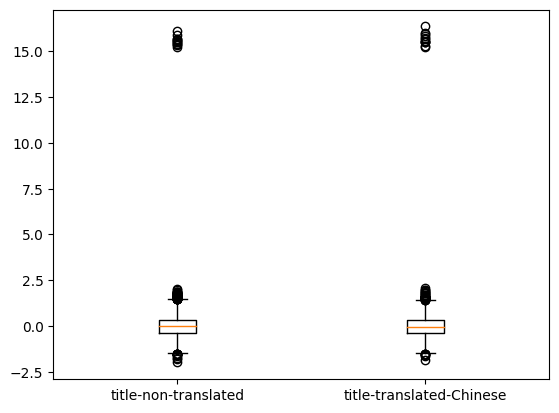

In [25]:
#box plot titles untranslated vs translate thru Chinese
plt.boxplot([titles_specters_en.reshape(-1), translated_titles_specters_zh.reshape(-1)], labels=["title-non-translated", "title-translated-Chinese"])

In [26]:
translated_abstracts_zh = translate_en_zh_en(abstracts)
translated_abstracts_specters_zh = get_specters(translated_abstracts_zh)

Your input_length: 504 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


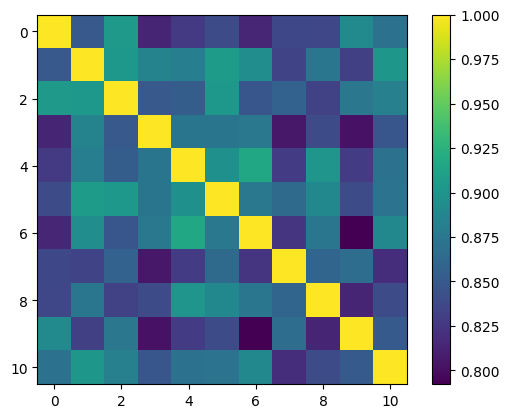

In [27]:
##plot for untranslated thru Chinese abstracts specters
plot_cossim(translated_abstracts_specters_zh)

{'whiskers': [<matplotlib.lines.Line2D at 0x7cb39d0fdc90>,
 'caps': [<matplotlib.lines.Line2D at 0x7cb39d0fe1d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7cb39d0fd9f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7cb39d0fe710>,
 'fliers': [<matplotlib.lines.Line2D at 0x7cb39d0fe9b0>,
 'means': []}

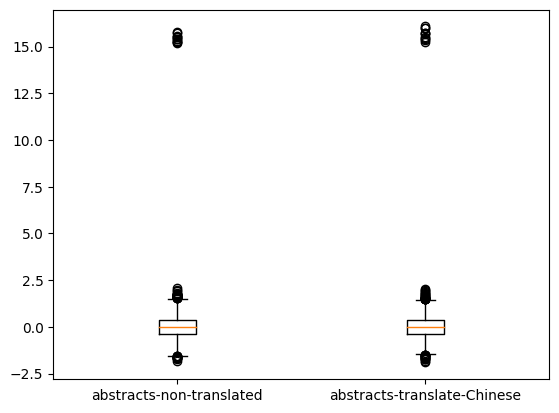

In [28]:
#box plot abstracts untranslated vs translate thru Chinese
plt.boxplot([abstracts_specters_en.reshape(-1), translated_abstracts_specters_zh.reshape(-1)], labels=["abstracts-non-translated", "abstracts-translate-Chinese"])

In [29]:
translated_titles_fr = translate_en_fr_en(titles)
translated_titles_specters_fr = get_specters(translated_titles_fr)

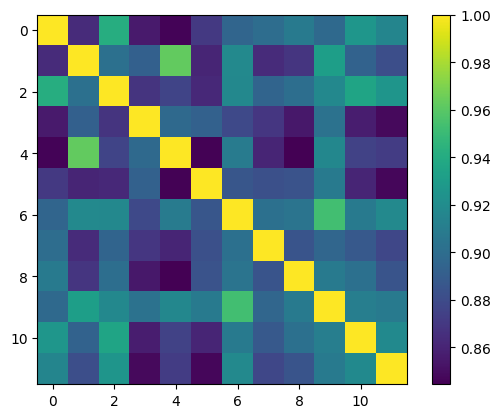

In [30]:
##plot for untranslated thru French titles specters
plot_cossim(translated_titles_specters_fr)

{'whiskers': [<matplotlib.lines.Line2D at 0x7cb39cebdcc0>,
 'caps': [<matplotlib.lines.Line2D at 0x7cb39cebe0e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7cb39cebda20>,
 'medians': [<matplotlib.lines.Line2D at 0x7cb39cebe620>,
 'fliers': [<matplotlib.lines.Line2D at 0x7cb39cebe8c0>,
 'means': []}

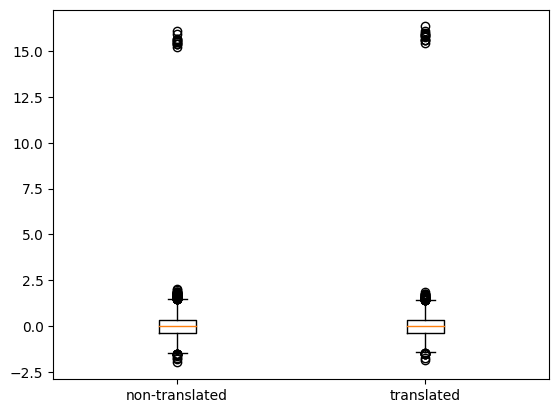

In [31]:
##box plot titles untranslated vs translate thru French
plt.boxplot([titles_specters_en.reshape(-1), translated_titles_specters_fr.reshape(-1)], labels=["titles-non-translated", "titles-translated-French"])

In [32]:
translated_abstracts_fr = translate_en_fr_en(abstracts)
translated_abstracts_specters_fr = get_specters(translated_abstracts_fr)

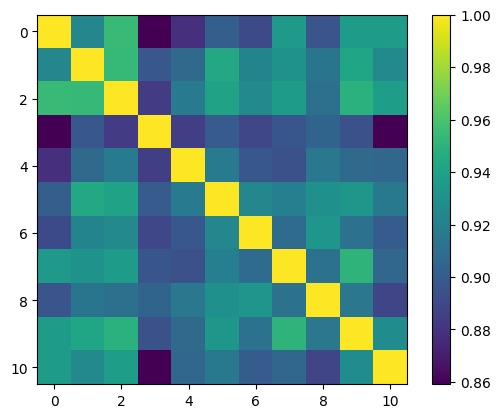

In [33]:
##plot for untranslated thru French abstracts specters
plot_cossim(translated_abstracts_specters_fr)

{'whiskers': [<matplotlib.lines.Line2D at 0x7cb39c8b6a40>,
 'caps': [<matplotlib.lines.Line2D at 0x7cb39c8b6f80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7cb39c8b67a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7cb39c8b74c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7cb39c8b7760>,
 'means': []}

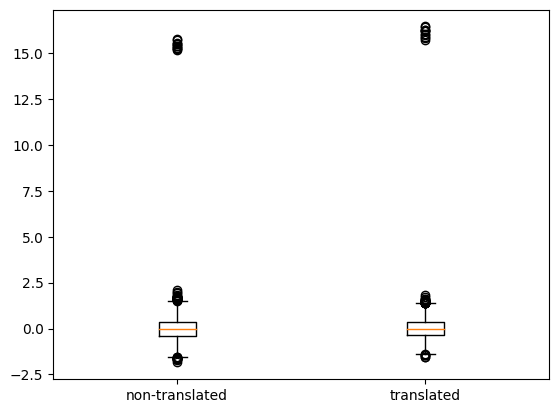

In [34]:
##box plot abstracts untranslated vs translate thru French
plt.boxplot([abstracts_specters_en.reshape(-1), translated_abstracts_specters_fr.reshape(-1)], labels=["abstracts-non-translated", "abstracts-translated-French"])